In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/validation/images/image_3681.png
/kaggle/input/validation/images/image_3168.png
/kaggle/input/validation/images/image_1084.png
/kaggle/input/validation/images/image_3408.png
/kaggle/input/validation/images/image_1534.png
/kaggle/input/validation/images/image_1276.png
/kaggle/input/validation/images/image_3724.png
/kaggle/input/validation/images/image_1415.png
/kaggle/input/validation/images/image_583.png
/kaggle/input/validation/images/image_3401.png
/kaggle/input/validation/images/image_410.png
/kaggle/input/validation/images/image_3415.png
/kaggle/input/validation/images/image_2639.png
/kaggle/input/validation/images/image_3122.png
/kaggle/input/validation/images/image_991.png
/kaggle/input/validation/images/image_316.png
/kaggle/input/validation/images/image_1456.png
/kaggle/input/validation/images/image_1413.png
/kaggle/input/validation/images/image_2484.png
/kaggle/input/validation/images/image_1240.png
/kaggle/input/validation/images/image_3668.png
/kaggle/input/val

In [ ]:
import torch  
import torch.nn as nn  
from torchvision.models import resnet101  
from torchvision.models.resnet import ResNet101_Weights 
import os
import csv  
import shutil  
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50,deeplabv3_resnet101
from PIL import Image
from tqdm import tqdm
from tqdm.auto import tqdm
from torch import optim
from torchvision.transforms import functional as F
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision.models.segmentation as segmentation
from torchvision.transforms.functional import to_pil_image

class ECALayer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(ECALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)
    
    
    
class ModifiedResNet101(nn.Module):
    def __init__(self, pretrained=True):
        super(ModifiedResNet101, self).__init__()

        backbone = resnet101(weights=ResNet101_Weights.DEFAULT)

        self.firstconv = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

        if pretrained:
            self.firstconv.weight.data[:, :3, :, :] = backbone.conv1.weight.data[:, :3, :, :]
            torch.nn.init.xavier_uniform_(self.firstconv.weight.data[:, 3, :, :])

        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool

        self.layer1 = self._make_layer(backbone.layer1, ECALayer, 256)
        self.layer2 = self._make_layer(backbone.layer2, ECALayer, 512)
        self.layer3 = self._make_layer(backbone.layer3, ECALayer, 1024)
        self.layer4 = self._make_layer(backbone.layer4, ECALayer, 2048)

        del backbone.fc
        self.fc = None

    def _make_layer(self, layer, ECALayer, planes):
        layers = []
        for module in layer.children():
            if isinstance(module, nn.Sequential):
            
                new_block = self._add_eca_to_block(module, ECALayer, planes)
                layers.append(new_block)
            else:
                layers.append(module)
        return nn.Sequential(*layers)

    def _add_eca_to_block(self, block, ECALayer, planes):
       
        eca_block = nn.Sequential(
            block,
            ECALayer(planes)
        )
        return eca_block

    def forward(self, x):
        x = self.firstconv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x


class ASPP(nn.Module):
    def __init__(self, in_channels, atrous_rates):
        super(ASPP, self).__init__()
        out_channels = 256  
        self.blocks = []
        for rate in atrous_rates:
            self.blocks.append(nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate))
        self.blocks = nn.ModuleList(self.blocks)
        self.project = nn.Sequential(
            nn.Conv2d(len(atrous_rates) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),  
        )

    def forward(self, x):
        out = []
        for block in self.blocks:
            out.append(block(x))
        out = torch.cat(out, dim=1)
        return self.project(out)

class Decoder(nn.Module):
    def __init__(self, low_level_in_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_in_channels + 256, 256, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.last_conv = nn.Conv2d(256, num_classes, 1)
        self.eca = ECALayer(256)

    def forward(self, x, low_level_features):
       
        x = F.interpolate(x, size=low_level_features.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, low_level_features], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.eca(x)
        x = self.last_conv(x)
        return x
    
class Radiance4(nn.Module):
    def __init__(self, num_classes=2):
        super(Radiance4, self).__init__()

        self.backbone = ModifiedResNet101(pretrained=True)
        
        in_channels = 2048  

        atrous_rates = [6, 12, 18]
        self.aspp = ASPP(in_channels, atrous_rates)

     
        low_level_channels = 256  

        self.low_level_conv = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.decoder = Decoder(48, num_classes)
        self.upsample = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)

    def forward(self, x):
     
        x = self.backbone.firstconv(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

     
        low_level_features = None  
        for name, module in enumerate(self.backbone.layer1.children()):  
            if name == 0:  
                low_level_features = module(x)
                break

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.aspp(x)  
        low_level_features = self.low_level_conv(low_level_features)
        x = self.decoder(x, low_level_features)
        x = self.upsample(x)
        
        return x
    

model = Radiance4(num_classes=2)


In [ ]:
def load_image(file_path):
    return np.array(Image.open(file_path))


class LandslideDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, phase='train', transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks') 
        self.images = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
    
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        img = load_image(img_path)
        original_img = img.copy()
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('image', 'mask'))
        mask = load_image(mask_path)
      
        
        sample = {'image': img,  'mask': mask, 'original_img': original_img}
        
        if self.transforms:
            sample = self.transforms(sample)
            
        return sample

def transform(sample):
    image, mask, original_img = sample['image'], sample['mask'], sample['original_img']
    
    # Data augmentation
    if random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
        
    if random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
        
    if random.random() > 0.5:
        angle = random.choice([90, 180, 270])
        image = np.rot90(image, k=angle//90)
        mask = np.rot90(mask, k=angle//90)
        

    
    # Convert to PIL Image and apply transforms
    original_img= T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor()
    ])(original_img)
    image = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406,0.475], std=[0.229, 0.224, 0.225,0.223])
    ])(image)
    mask = T.Compose([
        T.ToPILImage(),
        T.Resize((224, 224), interpolation=Image.NEAREST),
        T.ToTensor()
    ])(mask)
    
    # Concatenate image and dem, and return the transformed sample
    return {'image': image, 'mask': mask, 'original_img': original_img}
# 根目录以及数据加载器

In [ ]:
train_root_dir = "/kaggle/input/landslides/test"  
val_root_dir = "/kaggle/input/landslides/validation"  
# 注意：这里应该使用一个独立的测试集目录  
test_root_dir = "/kaggle/input/landslides/test"  # 假设存在这样一个目录  
  
# 创建数据集实例  
train_dataset =  LandslideDataset(root_dir=train_root_dir, transforms=transform)  
val_dataset =  LandslideDataset(root_dir=val_root_dir, transforms=transform)  
test_dataset =  LandslideDataset(root_dir=test_root_dir, transforms=transform)  
  
# 创建DataLoader  
# 对于训练集，通常设置 shuffle=True 以随机打乱数据  
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)  
  
# 对于验证集和测试集，通常不需要打乱数据  
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)  
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)  

In [ ]:
# criterion = torch.nn.BCELoss()  
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).float()  
    acc = correct.sum() / correct.numel()  
    return acc
def train_one_epoch(epoch, model, dataloader, device):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Training")
    for batch in progress_bar:
        inputs = batch['image'].to(device,dtype=torch.float32)
        masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
       
       
        loss = criterion(outputs, masks)
        acc = calculate_accuracy(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_accuracy += acc.item()
        progress_bar.set_postfix({'Training Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy
def validate(epoch, model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Validation")
    with torch.no_grad():
        for batch in progress_bar:
            inputs = batch['image'].to(device,dtype=torch.float32)
            masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long)
            
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            acc = calculate_accuracy(outputs, masks)
            running_loss += loss.item()
            running_accuracy += acc.item()
            progress_bar.set_postfix({'Validation Loss': f"{loss.item():.4f}", 'Accuracy': f"{acc.item():.4f}"})
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / len(dataloader)
    print(f"Epoch {epoch} Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    return epoch_loss, epoch_accuracy

# 记录损失和准确率
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练周期
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, device)
    val_loss, val_acc = validate(epoch, model, val_loader, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

In [6]:
# 定义文件夹路径  
folder_path = '/kaggle/working/csv_directory'  
  
# 检查文件夹是否存在  
if os.path.exists(folder_path):  
      
    # 或者，如果你只是想清空文件夹而不是删除它，可以使用以下代码  
    for filename in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, filename)  
        try:  
            if os.path.isfile(file_path) or os.path.islink(file_path):  
                os.unlink(file_path)  
            elif os.path.isdir(file_path):  
                shutil.rmtree(file_path)  
        except Exception as e:  
            print(f'删除 {file_path} 时出错: {e}')  
      
    # 这里我们只是打印一条消息，而不是删除文件夹  
    print(f"文件夹 {folder_path} 已存在。")  
else:  
    # 文件夹不存在，创建它  
    os.makedirs(folder_path, exist_ok=True)  
    print(f"文件夹 {folder_path} 已创建。")


# 定义文件路径  
filename = '/kaggle/working/csv_directory/training_validation_results.csv'  
  
# 写入CSV文件  
with open(filename, mode='w', newline='') as file:  
    writer = csv.writer(file)  
      
    # 写入表头  
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])  
      
    # 遍历每个epoch，写入数据  
    for epoch in range(1, len(train_losses) + 1):  
        writer.writerow([epoch, train_losses[epoch-1], train_accuracies[epoch-1], val_losses[epoch-1], val_accuracies[epoch-1]])  
  
print(f'Results saved to {filename}')

文件夹 /kaggle/working/csv_directory 已创建。
Results saved to /kaggle/working/csv_directory/training_validation_results.csv


文件夹 /kaggle/working/loss_accuracy_directory 已创建。


<Figure size 1200x500 with 0 Axes>

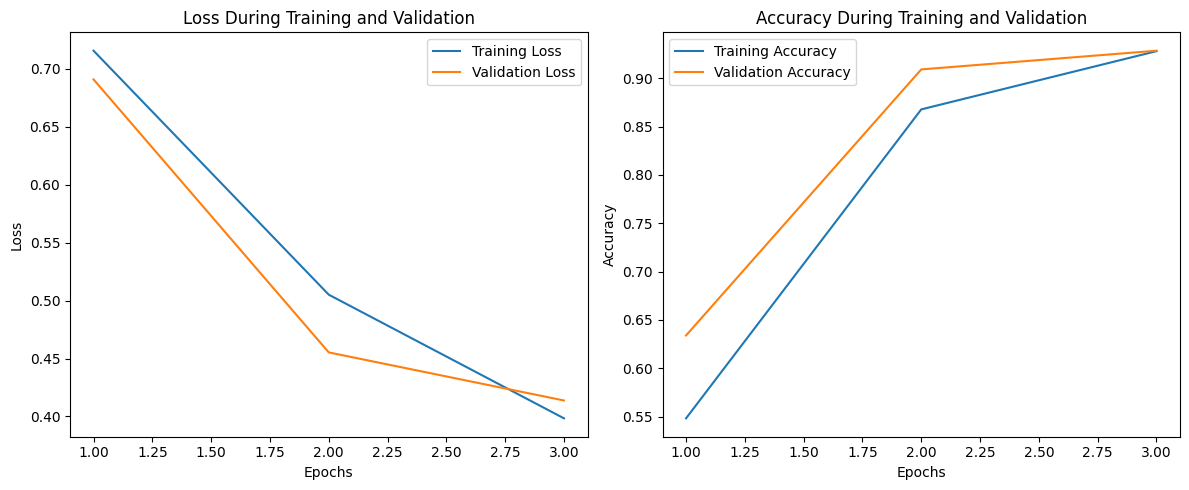

In [7]:
# 定义文件夹路径  
folder_path = '/kaggle/working/loss_accuracy_directory'  
  
# 检查文件夹是否存在  
if os.path.exists(folder_path):       
    for filename in os.listdir(folder_path):  
        file_path = os.path.join(folder_path, filename)  
        try:  
            if os.path.isfile(file_path) or os.path.islink(file_path):  
                os.unlink(file_path)  
            elif os.path.isdir(file_path):  
                shutil.rmtree(file_path)  
        except Exception as e:  
            print(f'删除 {file_path} 时出错: {e}')  
      
    # 这里我们只是打印一条消息，而不是删除文件夹  
    print(f"文件夹 {folder_path} 已存在。")  
else:  
    # 文件夹不存在，创建它  
    os.makedirs(folder_path, exist_ok=True)  
    print(f"文件夹 {folder_path} 已创建。")

# 绘图
plt.figure(figsize=(12, 5))

# 第一个子图 - 损失
plt.figure(figsize=(6, 5))  # 调整大小
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training and Validation')
plt.legend()
plt.tight_layout()  # 调整布局
plt.savefig("/kaggle/working/loss_accuracy_directory/training_validation_loss.png")  # 保存第一个子图
plt.close()  # 关闭当前图表

# 第二个子图 - 准确率
plt.figure(figsize=(6, 5))  # 调整大小
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training and Validation')
plt.legend()
plt.tight_layout()  # 调整布局
plt.savefig("/kaggle/working/loss_accuracy_directory/training_validation_accuracy.png")  # 保存第二个子图
plt.close()  # 关闭当前图表

# 创建一个包含两个子图的图表
plt.figure(figsize=(12, 5))

# 第一个子图 - 损失
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training and Validation')
plt.legend()

# 第二个子图 - 准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy During Training and Validation')
plt.legend()

# 调整子图布局
plt.tight_layout()

# 保存图表为文件
plt.savefig("/kaggle/working/loss_accuracy_directory/loss_and_accuracy.png")

# 显示图表
plt.show()

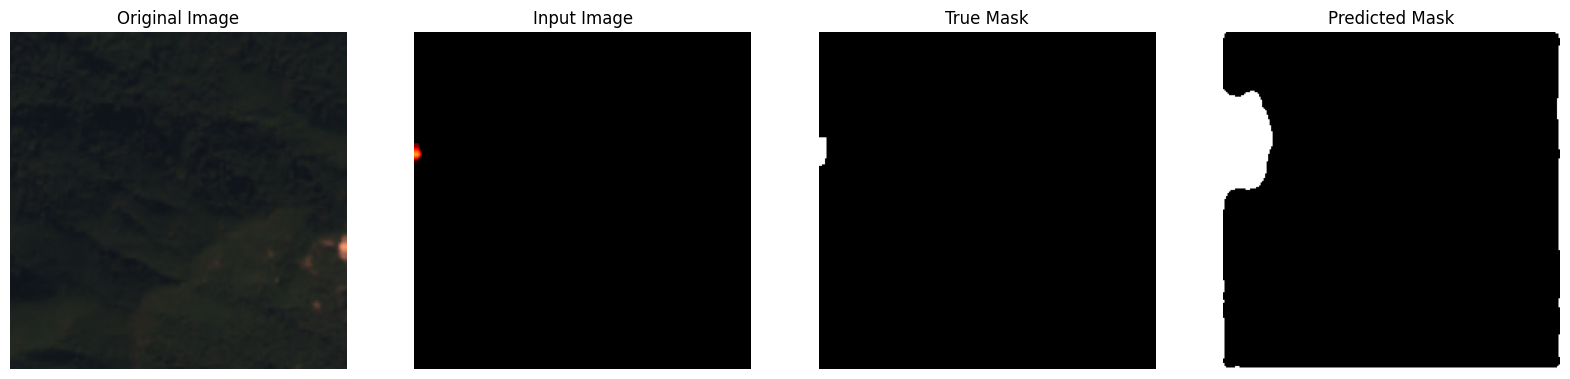

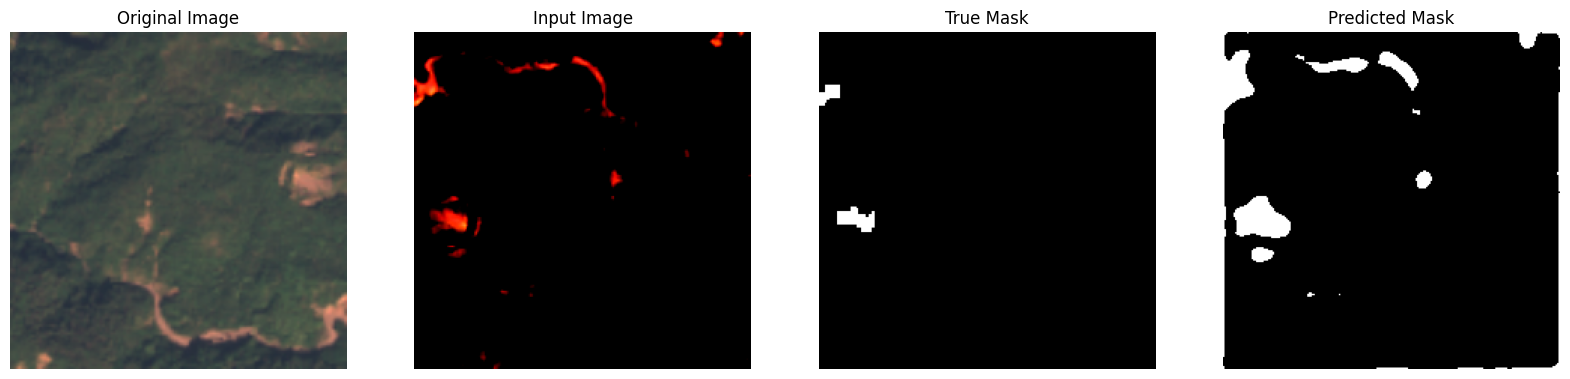

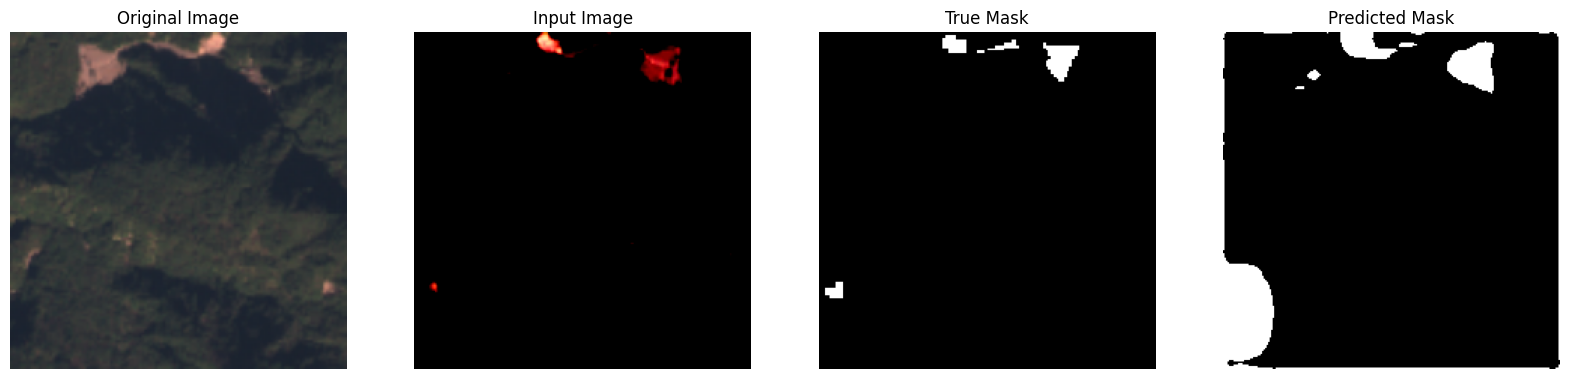

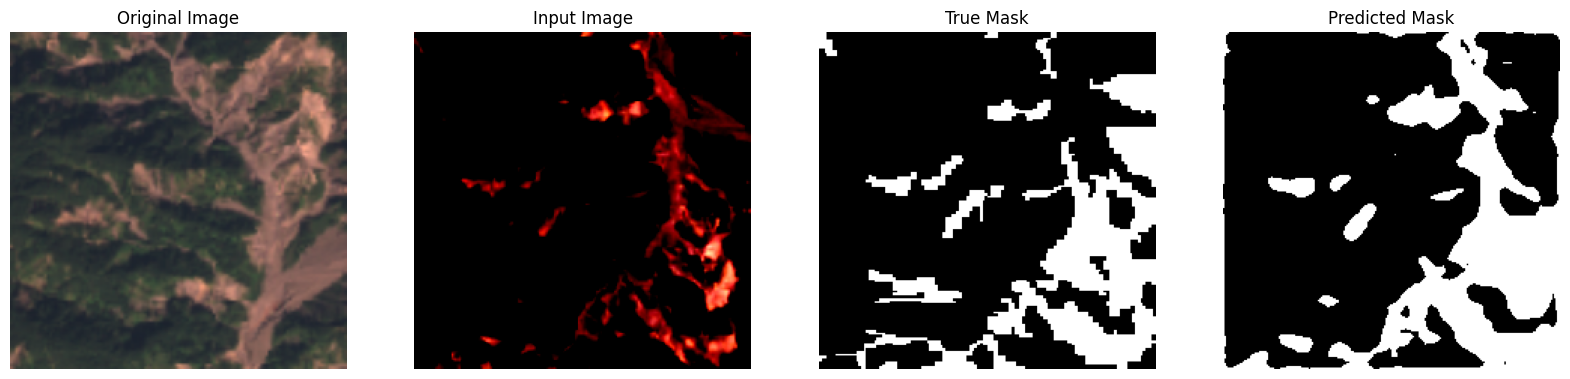

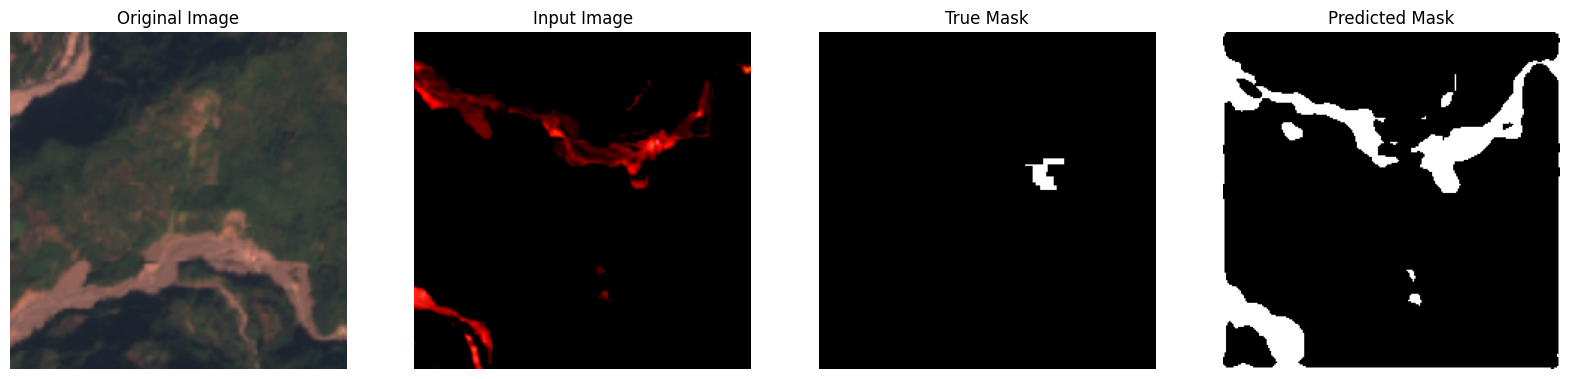

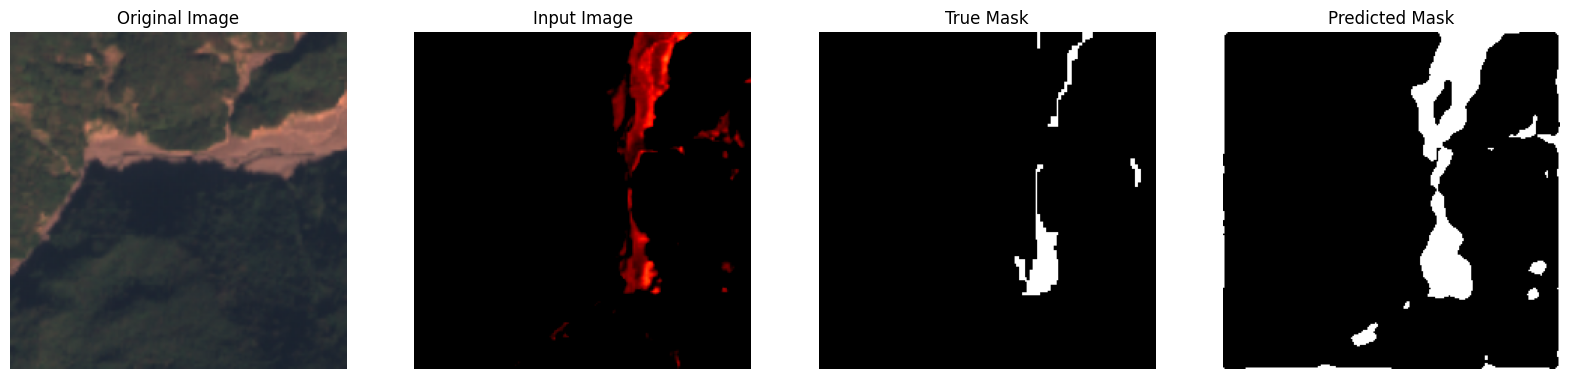

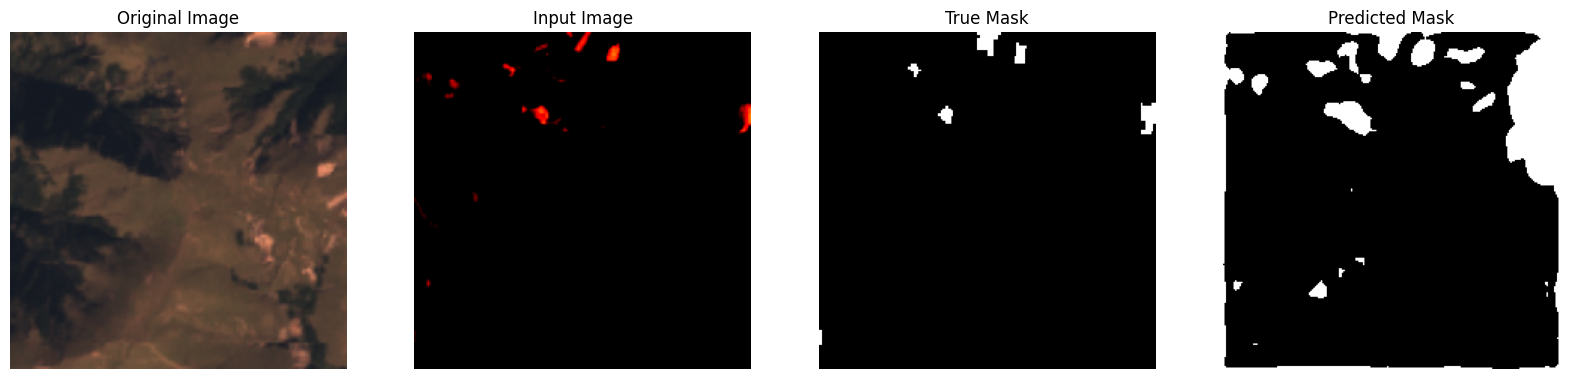

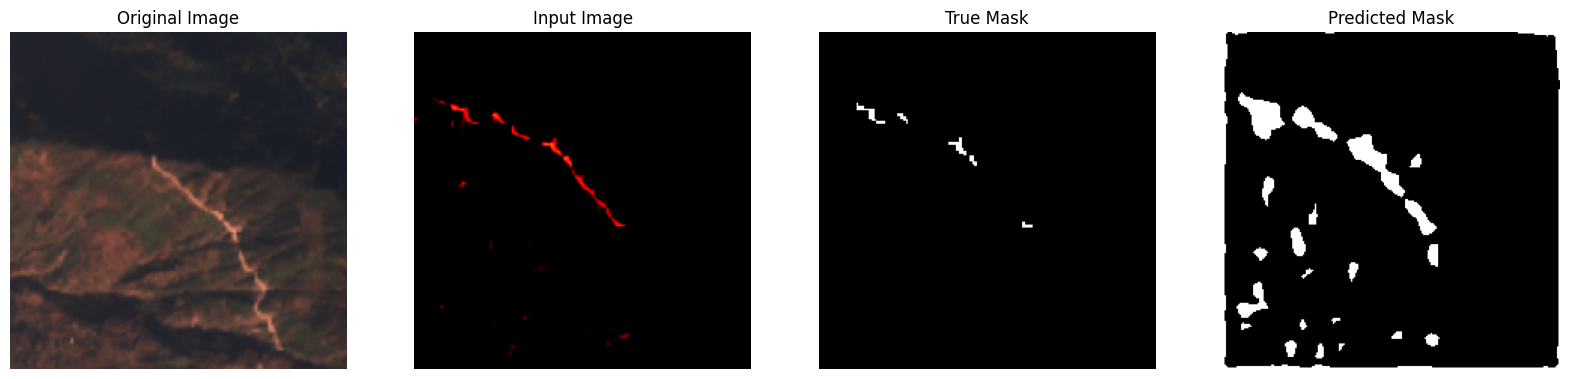

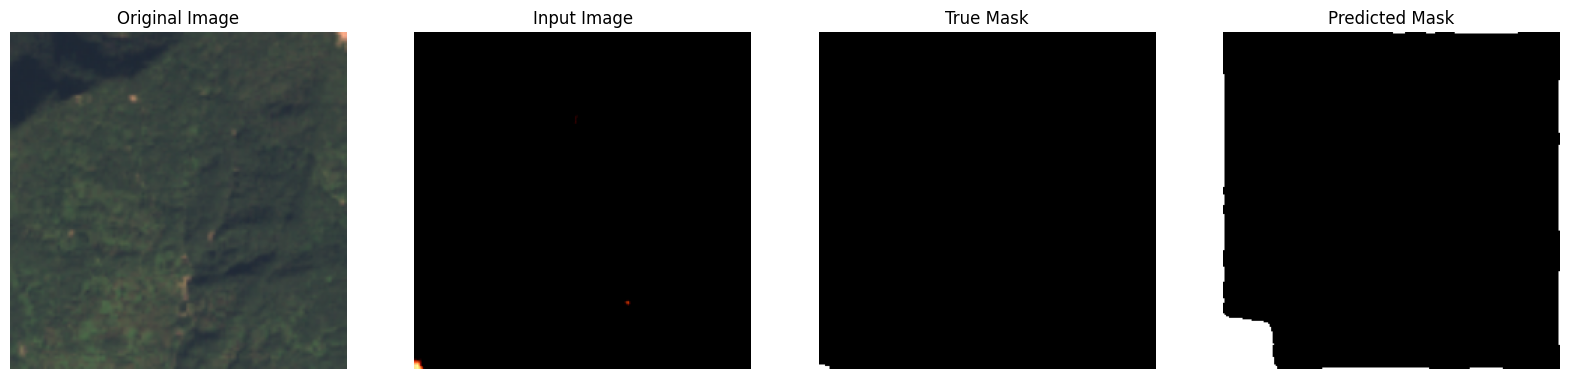

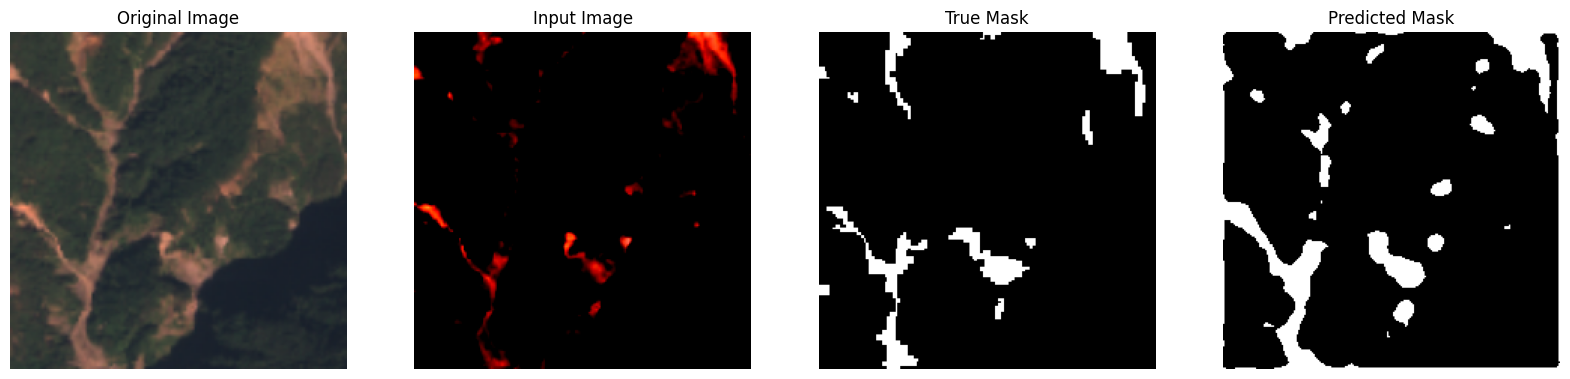

In [8]:
def denormalize(tensor, mean, std):
    """
    将标准化后的张量恢复到原始范围。
    :param tensor: (Tensor) 需要恢复的张量
    :param mean: (list) 图像通道的均值
    :param std: (list) 图像通道的标准差
    :return: (Tensor) 恢复后的张量
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def ensure_dir_empty(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        os.makedirs(directory)  

def visualize_predictions(dataset, model, device, num_examples=10, save_path='/kaggle/working/predict_directory'):
    model.eval()
    
    # 确保主目录为空
    ensure_dir_empty(save_path)
    
    # 创建子文件夹
    subfolders = ['Original Image', 'Input Image', 'True Mask', 'Predicted Mask']
    for folder in subfolders:
        # 使用 os.path.join 来组合路径
        subfolder_path = os.path.join(save_path, folder)
        # 使用 os.makedirs 创建子目录
        os.makedirs(subfolder_path, exist_ok=True)
    
    samples = torch.utils.data.Subset(dataset, range(num_examples))
    loader = DataLoader(samples, batch_size=1, shuffle=False)
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            inputs = batch['image'].to(device)
            originals = batch['original_img'].to(device)
            true_masks = batch['mask'][:, 0, :, :].squeeze(1).numpy()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            inputs = inputs.cpu().clamp(0, 1)
            originals = originals.cpu().clamp(0, 1)

            # 创建包含所有子图的大图
            fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 调整大小以适应所有子图
            
            # 绘制子图
            axs[0].imshow(originals.numpy()[0][0:3].transpose(1, 2, 0))
            axs[0].set_title('Original Image')
            axs[0].axis('off')

            axs[1].imshow(inputs.numpy()[0][0:3].transpose(1, 2, 0))
            axs[1].set_title('Input Image')
            axs[1].axis('off')

            axs[2].imshow(true_masks[0], cmap='gray')
            axs[2].set_title('True Mask')
            axs[2].axis('off')

            axs[3].imshow(preds[0], cmap='gray')
            axs[3].set_title('Predicted Mask')
            axs[3].axis('off')

            # 展示大图
            plt.show()

            # 保存图像到相应的子文件夹
            for j, subplot in enumerate(['Original Image', 'Input Image', 'True Mask', 'Predicted Mask']):
                plt.figure(figsize=(5, 5))  # 创建一个新的图像
                
                if subplot == 'Original Image':
                    plt.imshow(originals.numpy()[0][0:3].transpose(1, 2, 0))
                elif subplot == 'Input Image':
                    plt.imshow(inputs.numpy()[0][0:3].transpose(1, 2, 0))
                elif subplot == 'True Mask':
                    plt.imshow(true_masks[0], cmap='gray')
                elif subplot == 'Predicted Mask':
                    plt.imshow(preds[0], cmap='gray')
                
                plt.axis('off')
                
                # 保存图像
                plt.savefig(os.path.join(save_path, subplot, f'{subplot}_{i+1}.png'), bbox_inches='tight', pad_inches=0)
                plt.close()  # 关闭图像，避免内存泄漏
  
# 示例  
visualize_predictions(test_dataset, model, device, num_examples=10)

Epoch 1 Test:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 Test Results: Precision: 0.6613, Recall: 0.8331, F1 Score: 0.7094, mIoU: 0.2454


Epoch 2 Test:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2 Test Results: Precision: 0.6630, Recall: 0.8359, F1 Score: 0.7116, mIoU: 0.2462


Epoch 3 Test:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3 Test Results: Precision: 0.6626, Recall: 0.8373, F1 Score: 0.7114, mIoU: 0.2460
Total 3 Average Precision: 0.6623, Average Recall: 0.8354, Average F1 Score: 0.7108, Average mIoU: 0.2459


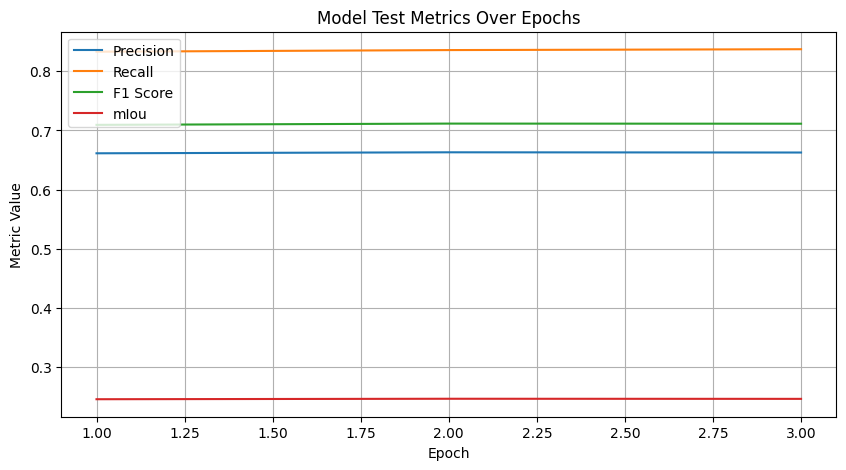

Normalized confusion matrix


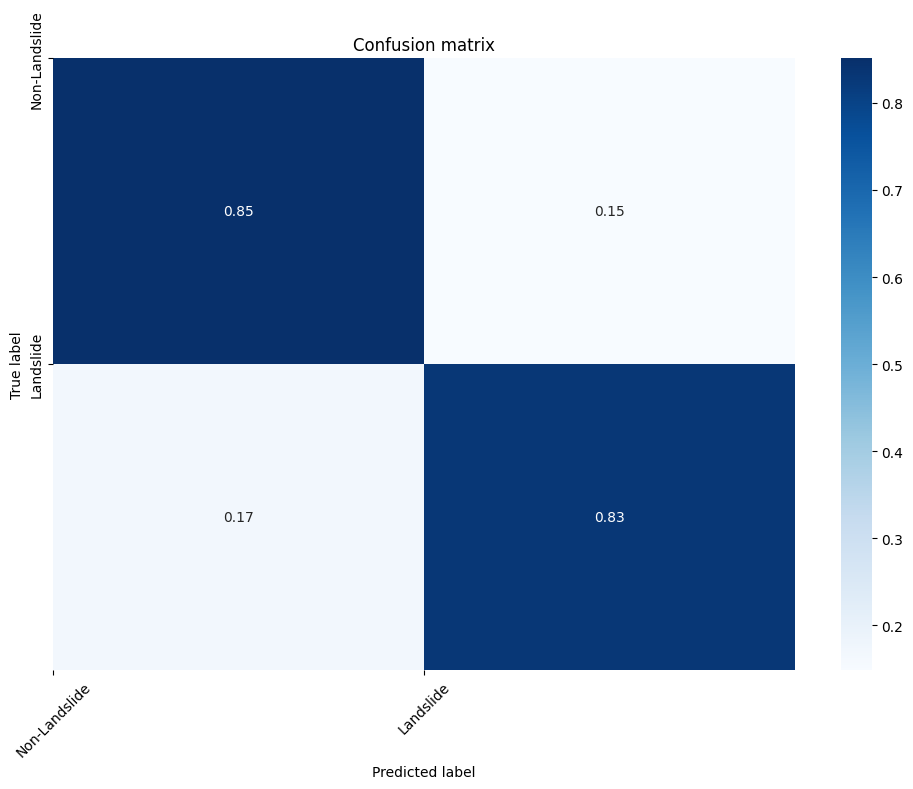

In [9]:
dir_path = '/kaggle/working/confusion matrix_directory'
os.makedirs(dir_path, exist_ok=True)
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix

def evaluate_metrics(model, dataloader, device,epoch):  
    model.eval()  
    all_preds, all_true = [], [] 
    all_predicts,all_targets = [],[]
    progress_bar = tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch} Test")  
    with torch.no_grad():  
        for batch in progress_bar:  
            inputs = batch['image'].to(device)  
            true_masks = batch['mask'][:, 0, :, :].to(device, dtype=torch.long).squeeze(1)  
            outputs = model(inputs)  
            preds = torch.argmax(outputs, dim=1) 
            all_preds.append(preds)  
            all_true.append(true_masks)  
  
  
        # 合并所有预测和真实标签  
        all_preds = torch.cat(all_preds, dim=0).cpu().numpy()  
        all_true = torch.cat(all_true, dim=0).cpu().numpy()  
  
        # 计算IoU和mIoU  
        intersection = (all_preds & all_true).astype(np.float32)  
        union = (all_preds | all_true).astype(np.float32)  
        iou_per_image = (np.sum(intersection, axis=(1, 2)) + 1e-7) / (np.sum(union, axis=(1, 2)) + 1e-7)  
        mIou = np.mean(iou_per_image)  
  
        # 计算precision, recall, f1  
        precision = precision_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        recall = recall_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        f1 = f1_score(all_true.flatten(), all_preds.flatten(), average='macro')  
        
        
          # 将模型输出转换为预测标签
        
        all_predicts.extend(preds.view(-1).cpu().numpy())  # 转换为一维数组
            
            # 将真实标签转换为一维数组
        all_targets.extend(true_masks.view(-1).cpu().numpy())
        cm = confusion_matrix(all_targets, all_predicts)
        
        
  
        # 打印结果  
        print(f"Epoch {epoch} Test Results: Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mIoU: {mIou:.4f}")
    return precision, recall, f1, mIou ,cm
  
metrics_history = {'precision': [], 'recall': [], 'f1': [], 'mIou': []}

def plot_metrics(metrics_history,save_dir='/kaggle/working/saved_plots', filename='metrics_over_epochs.png'):
    ensure_dir_empty(save_dir)
    epochs = range(1, len(metrics_history['f1']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics_history['precision'], label='Precision')
    plt.plot(epochs, metrics_history['recall'], label='Recall')
    plt.plot(epochs, metrics_history['f1'], label='F1 Score')
    plt.plot(epochs, metrics_history['mIou'], label='mIou')
    plt.title('Model Test Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend(loc='upper left') 
    plt.grid(True)
    save_path = "/kaggle/working/saved_plots/metrics_over_epochs.png"  
    plt.savefig(save_path)  
    plt.show()
    


def plot_confusion_matrix(val_cm, classes=None, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        val_cm = val_cm.astype('float') / val_cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(10, 8))
    sns.heatmap(val_cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if classes is not None:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/confusion matrix_directory/confusion matrix.png')
    plt.show()
    

for epoch in range(1, num_epochs + 1):
    precision, recall, f1, mIou,test_cm= evaluate_metrics(model, test_loader, device,epoch)
    metrics_history['precision'].append(precision)
    metrics_history['recall'].append(recall)
    metrics_history['f1'].append(f1)
    metrics_history['mIou'].append(mIou)  
  
  
# 计算平均值  
avg_precision = np.mean(metrics_history['precision'])  
avg_recall = np.mean(metrics_history['recall'])  
avg_f1 = np.mean(metrics_history['f1'])  
avg_miou = np.mean(metrics_history['mIou'])  
   
print(f"Total {num_epochs} Average Precision: {avg_precision:.4f}, Average Recall: {avg_recall:.4f}, Average F1 Score: {avg_f1:.4f}, Average mIoU: {avg_miou:.4f}")  
  

plot_metrics(metrics_history,save_dir='/kaggle/working/saved_plots')
plot_confusion_matrix(test_cm, classes=['Non-Landslide', 'Landslide'], normalize=True)